# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st 

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
display('Region0',data_0.head())
display('Region1',data_1.head())
display('Region2',data_2.head())

'Region0'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Region1'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Region2'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Вот наши рабочие данные, 4 столбца со значениями, и столбец с id скважины. К сожалению у нас нет данные по столбцам f, это условные показатели качества нефти. Рассматривать их я не буду в дальнешем анализе, но будем на основании их обучать модель.

In [5]:
display('Region0',data_0.describe())
display('Region1',data_1.describe())
display('Region2',data_2.describe())

'Region0'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Region1'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Region2'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


По собранным параметрам данных можно заключить, что среднее ст отклонения объемов добычи нефти примерно одинаковы по всех регионах. Максимальные значения по каждой скважине имеются во 2 регионе, наименьшее максимальное значение имеется в 1. В Целом распределение добычи нефти хорошо видно по гистограммам, ниже посмотрим на них.

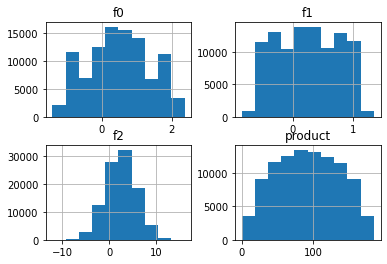

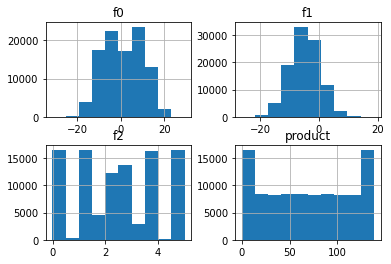

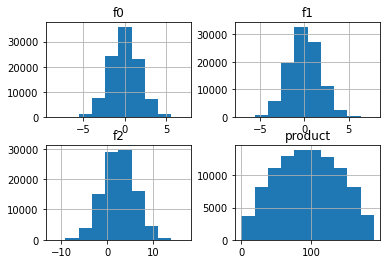

In [6]:
data_0.hist();
data_1.hist();
data_2.hist();

Распределение параметров в регионе 1 отличается от 0 и 2. Возможно это скажется на резульатах. Пока это выглядит так, что регионы 0 и 2 чем-то схожы, а 1 должен иметь отличия по добычи и качеству нефти.

In [7]:
regions=[data_0,data_1,data_2]

Проверка на дубликаты

In [8]:
for i in regions:
    print(i[i.duplicated()])

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []


In [9]:
for i in regions:
    print(i[i.duplicated(subset = ['id'])])

          id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
          id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839  2.191999  3.993869  107.813044
          id        f0        f1        f2     product
43233  xCHr8 -0.847066  2.101796  5.597130  184.3

Есть дубликаты по id скважины, я думаю их немного, и можно спокойно их отбросить

In [10]:
for i in regions:
    i=(i.drop_duplicates(subset = ['id']))
    i=i.reset_index(drop=True)
    print(i[i.duplicated(subset = ['id'])])

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []
Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []


Убрал дубликаты. Далее необходимо убрать столбец id, он более не пригодится. И посмотрим как выглядят таблицы с данными теперь:

In [11]:
data_0=data_0.drop(['id'],axis=1)
data_1=data_1.drop(['id'],axis=1)
data_2=data_2.drop(['id'],axis=1)
regions=[data_0,data_1,data_2]
display('Region0',data_0.head())
display('Region1',data_1.head())
display('Region2',data_2.head())


'Region0'

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


'Region1'

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


'Region2'

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [12]:
def split_data(data,target): 
    data_train, data_valid = train_test_split(data, test_size=0.25, random_state=42, shuffle = True)
    target_train= data_train[target]
    features_train = data_train.drop([target],axis=1)
    target_valid= data_train[target]
    features_valid = data_train.drop([target],axis=1)
    return features_train, target_train,features_valid,target_valid

In [13]:
feat_dict={'features_train':[],'target_train':[],'features_valid':[],'target_valid':[]}


In [14]:
for i in regions:
    features_train, target_train,features_valid,target_valid=split_data(i,'product')
    feat_dict['features_train'].append(features_train)
    feat_dict['target_train'].append(target_train)
    feat_dict['features_valid'].append(features_valid)
    feat_dict['target_valid'].append(target_valid)

In [15]:
display(feat_dict['features_train'][2])
display(feat_dict['target_train'][2])

,f0,f1,f2
98980,-0.592927,-2.323059,5.344840
69824,-0.690844,1.715501,-1.331142
9928,1.741680,-1.604639,0.499745
75599,-1.354850,0.984588,5.683113
95621,1.075114,1.175117,1.010025
...,...,...,...
6265,-1.842672,-0.003145,0.926830
54886,0.079216,1.076507,3.761491
76820,-2.285696,1.500897,-1.051454
860,-1.446403,-2.164471,3.334692


98980    122.402114
69824     43.299623
9928     144.915121
75599    114.038791
95621     95.600308
            ...    
6265      54.598839
54886     63.428292
76820     37.780858
860       68.317185
15795    147.700315
Name: product, Length: 75000, dtype: float64

## Обучение и проверка модели

In [16]:
models=[LinearRegression()]

In [17]:

for i in models:
    pipe=make_pipeline(StandardScaler(),i)
    sum_score=0
    mean_cv_score_reg=0
    for reg_n in [0,1,2]:
        mean_cv_score=cross_val_score(pipe,feat_dict['features_train'][reg_n],
                                      feat_dict['target_train'][reg_n],cv=5,scoring='neg_root_mean_squared_error').mean()
        sum_score+=mean_cv_score
        top_cv_score=mean_cv_score
        top_model=i
        print('Region num=',reg_n,'|','RMSE',top_cv_score,'|',top_model)
    print('Средний скор RMSE модели по всем регионам=',sum_score/3)
    print('///'*25)

Region num= 0 | RMSE -37.67200536313506 | LinearRegression()
Region num= 1 | RMSE -0.8904559629285671 | LinearRegression()
Region num= 2 | RMSE -40.02698159997838 | LinearRegression()
Средний скор RMSE модели по всем регионам= -26.196480975347338
///////////////////////////////////////////////////////////////////////////


Получаем RMSE скор по 3 регионам 

In [18]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [19]:
for i in models:
    pipe=make_pipeline(StandardScaler(),i)
    sum_score=0
    mean_cv_score_reg=0
    for reg_n in [0,1,2]:
        mean_cv_score=cross_val_score(pipe,feat_dict['features_train'][reg_n],
                                      feat_dict['target_train'][reg_n],cv=5).mean()
        sum_score+=mean_cv_score
        top_cv_score=mean_cv_score
        top_model=i
        print('Region num=',reg_n,'|','Score',top_cv_score,'|',top_model)
    print('Средний скор модели по всем регионам=',sum_score/3)
    print('///'*25)

Region num= 0 | Score 0.27646862289690327 | LinearRegression()
Region num= 1 | Score 0.9996243124448292 | LinearRegression()
Region num= 2 | Score 0.1994800504549819 | LinearRegression()
Средний скор модели по всем регионам= 0.4918576619322381
///////////////////////////////////////////////////////////////////////////


Проведено два расчета по подсчету скора кросс-валидации

In [33]:
param={'fit_intercept':[True,False],
       'copy_X':[True,False],

    
}

grd=RandomizedSearchCV(LinearRegression(),
                       param_distributions=param,cv=5,
                       scoring='neg_root_mean_squared_error', n_jobs=8,random_state=42, verbose=False)

pipe=make_pipeline(StandardScaler(),grd)
model_dict={'best_estimator':[]}
for i in [0,1,2]:
    
    pipe.fit(feat_dict['features_train'][i],
                                      feat_dict['target_train'][i])
    model_dict['best_estimator'].append(grd.best_estimator_)
    print('Region=',i,'|',grd.best_score_,'|',grd.best_params_,)
    print('Лучшая модель:',grd.best_estimator_)
    print('////'*30)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Region= 0 | -37.67200536313506 | {'fit_intercept': True, 'copy_X': True}
Лучшая модель: LinearRegression()
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Region= 1 | -0.8904559629285673 | {'fit_intercept': True, 'copy_X': True}
Лучшая модель: LinearRegression()
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Region= 2 | -40.02698159997838 | {'fit_intercept': True, 'copy_X': True}
Лучшая модель: LinearRegression()
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


In [34]:
model_dict

{'best_estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression()]}

In [35]:
def find_rmse(target, predicted):
    return mean_squared_error(target, predicted) ** 0.5


In [46]:
dict_predict={'predict':[]}
dict_rmse={'rmse':[],
           'mean_pred':[],
           'mean_valid':[]
}
for i in [0,1,2]:
    pipe=make_pipeline(StandardScaler(),LinearRegression())
    predict=pipe.fit(feat_dict['features_train'][i],
             feat_dict['target_train'][i]).predict(feat_dict['features_valid'][i])
    dict_predict['predict'].append(predict)
    rmse=find_rmse(feat_dict['target_valid'][i],predict)
    dict_rmse['rmse'].append(rmse)
    dict_rmse['mean_pred'].append(predict.mean())
    dict_rmse['mean_valid'].append(feat_dict['target_valid'][i].mean())
    print("Ошибка по региону ",i,'RMSE=',rmse)
                       

Ошибка по региону  0 RMSE= 37.67049903536212
Ошибка по региону  1 RMSE= 0.8904196385265012
Ошибка по региону  2 RMSE= 40.025181468019824


In [47]:
dict_rmse

{'rmse': [37.67049903536212, 0.8904196385265012, 40.025181468019824],
 'mean_pred': [92.55801454305207, 68.85820641759084, 94.94966697609351],
 'mean_valid': [92.55801454305207, 68.85820641759085, 94.9496669760935]}

In [48]:
pd.DataFrame(dict_rmse)

,rmse,mean_pred,mean_valid
0,37.670499,92.558015,92.558015
1,0.890420,68.858206,68.858206
2,40.025181,94.949667,94.949667


Вывод: по результатам обучения и предсказания модели видно, что наименьшая ошибка RMSE получена в первом регионе,наибольшая во 2-м. Средние значения получились одинаковые по валидным выборкам и предикту.

## Подготовка к расчёту прибыли

In [39]:
Budget = 10000000000
Price = 450000
Oil_best = 200
print('Объём сырья для безубыточной разработки новой скважины: ', Budget / Price / Oil_best)

Объём сырья для безубыточной разработки новой скважины:  111.11111111111111


In [40]:
print('Средний объем запасов скважины в 0-м регионе: ', data_0['product'].mean())
print('Средний объем запасов скважины в 1-м регионе: ', data_1['product'].mean())
print('Средний объем запасов скважины в 2-м регионе: ', data_2['product'].mean())

Средний объем запасов скважины в 0-м регионе:  92.50000000000001
Средний объем запасов скважины в 1-м регионе:  68.82500000000002
Средний объем запасов скважины в 2-м регионе:  95.00000000000004


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Нас просили сравнить объём сырья для безубыточной разработки новой скважины со средними запасами в каждом регионе - это подразумевает под собой написание небольшого вывода.
     
  
</div>

In [50]:
print('Средний объем запасов скважины в 0-м регионе: ', data_0['product'].mean())
print('Средний объем запасов скважины в 1-м регионе: ', data_1['product'].mean())
print('Средний объем запасов скважины в 2-м регионе: ', data_2['product'].mean())
print('Объём сырья для безубыточной разработки новой скважины: ', Budget / Price / Oil_best)

Средний объем запасов скважины в 0-м регионе:  92.50000000000001
Средний объем запасов скважины в 1-м регионе:  68.82500000000002
Средний объем запасов скважины в 2-м регионе:  95.00000000000004
Объём сырья для безубыточной разработки новой скважины:  111.11111111111111


Вывод: Видим, что ни один регион не показаыват объемов, привышающих безубыточный объем. Особенно плохо выглядит первый регион. Что ж, я думаю это изменится если мы будем оценивать в дальнейшем риски по заданному ТЗ.

## Расчёт прибыли и рисков 

In [41]:


def revenue(target, predictions, cost, count):
    probs_sorted = pd.Series(predictions,index=target.index).sort_values(ascending=False)
    selected = target[probs_sorted.index][:count] 
    return cost * selected.sum()-Budget

In [42]:
def bootsrtap(target, predictions):
    state = np.random.RandomState(42)

    values = []
    for i in range(1000):
        new_target = target.reset_index(drop=True).sample(replace = True, random_state = state, n = 500)
        
        new_predictions = predictions[new_target.index.values]

        values.append(revenue(new_target, new_predictions, Price, 200))

    values = pd.Series(values)
    return values

In [43]:
def mean_revenue(values):
    return round(values.mean()/1000000,0)
    
    
def dint_95(values):
    return round((values.quantile(0.025))/1000000,1),round((values.quantile(0.975))/1000000,1)
    
    
def risk_of_loss(values):
    return st.percentileofscore(values, 0)
    

In [44]:
dict_result={'Средняя выручка,млн':[],
             'Доверительный интервал 95%: млн':[],
             'Риск_убытков,%':[]
    
}
for i in [0,1,2]:
    raspred = bootsrtap(feat_dict['target_valid'][i], dict_predict['predict'][i])
    mean_r=mean_revenue(raspred)
    dov_interval=dint_95(raspred)
    r=risk_of_loss(raspred)
    dict_result['Средняя выручка,млн'].append(mean_r)
    dict_result['Доверительный интервал 95%: млн'].append(dov_interval)
    dict_result['Риск_убытков,%'].append(r)

In [45]:
pd.DataFrame(dict_result,index=['Регион 0','Регион 1','Регион 2'])

,"Средняя выручка,млн",Доверительный интервал 95%: млн,"Риск_убытков,%"
Регион 0,448.0,"(-93.5, 964.8)",5.1
Регион 1,474.0,"(85.3, 895.8)",1.2
Регион 2,372.0,"(-142.8, 912.5)",8.8


#### Вывод

В ходе выполнения проекта были проанализированны данные добычи нефти в скважинах по 3-м регионам. Была построена линейная модель предсказания объемов добычи.

По выполненому решению можно заключить что только Регион 1 подходит под условие, где вероятность убытков меньше 2.5%, а именно 1.2%. Таким образом, рекомендую начинать бурение в первом регионе.

Можно заметить интересную ситуацию, что хоть по средним объемам добычи первый регион был аутсайдером. А по рискам он вышел менее рисковый и почти лучший по средней выручке (разница минимальна по сравннию с регионом 0)